In [229]:
import os.path
import pandas as pd
from Bio.PDB import PDBParser
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Reshape, Dense

In [230]:
data = pd.read_excel(r"C:\Users\eminm\OneDrive\Desktop\Protein Docking\ProteinDockingKod\data\easy_proteins.xlsx")
data.head(100)

,Complex,Cat.,PDB ID 1,Protein 1,PDB ID 2,Protein 2,I-RMSD,ASA,BM version introduced
0,1AHW_AB:C,AA,1FGN_LH,Fab 5g9,1TFH_A,Tissue factor,0.69,1899,2.0
1,1DQJ_AB:C,AA,1DQQ_CD,Fab Hyhel63,3LZT_,HEW lysozyme,0.75,1765,2.0
2,1E6J_HL:P,AA,1E6O_HL,Fab,1A43_,HIV-1 capsid protein p24,1.05,1245,2.0
3,1JPS_HL:T,AA,1JPT_HL,Fab D3H44,1TFH_B,Tissue factor,0.51,1852,2.0
4,1MLC_AB:E,AA,1MLB_AB,Fab44.1,3LZT_,HEW lysozyme,0.60,1392,2.0
...,...,...,...,...,...,...,...,...,...
95,3A4S_A:D,EI,1A3S_A,SUMO-conjugating enzyme UBC9,3A4R_A,NFATC2-interacting protein SLD2 ubiquitin-like...,0.72,1116,5.0
96,3K75_D:B,ER,1BPB_A,DNA polymerase beta,3K77_A,"Reduced XRCC1, N-terminal domain",0.64,1195,5.0
97,3LVK_AC:B,ER,3LVM_AB,Cysteine desulfurase IscS,1DCJ_A(12),Sulfurtransferase tusA,0.81,1609,5.0
98,3PC8_A:C,ER,3PC6_A,DNA repair protein XRCC1,3PC7_A,DNA ligase III-alpha BRCT domain,0.50,1240,5.0


In [231]:
data = data.drop(["Cat.", "Protein 1", "Protein 2", "ASA", "BM version introduced"], axis=1)
data.head(100)

,Complex,PDB ID 1,PDB ID 2,I-RMSD
0,1AHW_AB:C,1FGN_LH,1TFH_A,0.69
1,1DQJ_AB:C,1DQQ_CD,3LZT_,0.75
2,1E6J_HL:P,1E6O_HL,1A43_,1.05
3,1JPS_HL:T,1JPT_HL,1TFH_B,0.51
4,1MLC_AB:E,1MLB_AB,3LZT_,0.60
...,...,...,...,...
95,3A4S_A:D,1A3S_A,3A4R_A,0.72
96,3K75_D:B,1BPB_A,3K77_A,0.64
97,3LVK_AC:B,3LVM_AB,1DCJ_A(12),0.81
98,3PC8_A:C,3PC6_A,3PC7_A,0.50


In [232]:
data['Complex'] = data['Complex'].str.split('_').str.get(0)
data['PDB ID 1'] = data['PDB ID 1'].str.split('_').str.get(0)
data['PDB ID 2'] = data['PDB ID 2'].str.split('_').str.get(0)
data.head(100)

,Complex,PDB ID 1,PDB ID 2,I-RMSD
0,1AHW,1FGN,1TFH,0.69
1,1DQJ,1DQQ,3LZT,0.75
2,1E6J,1E6O,1A43,1.05
3,1JPS,1JPT,1TFH,0.51
4,1MLC,1MLB,3LZT,0.60
...,...,...,...,...
95,3A4S,1A3S,3A4R,0.72
96,3K75,1BPB,3K77,0.64
97,3LVK,3LVM,1DCJ,0.81
98,3PC8,3PC6,3PC7,0.50


In [233]:
ligands = []
receptors = []
complexs = []
rmsds = []

atom_to_index = {atom: i for i, atom in enumerate(imena_atoma)}

# One-hot encoding function
def one_hot_encode(atom_name):
    encoding = [0] * len(imena_atoma)
    if atom_name in atom_to_index:
        encoding[atom_to_index[atom_name]] = 1
    return encoding

for protein, rmsd in zip(data["Complex"], data["I-RMSD"]):
    if os.path.exists(f'../data/pdbs/{protein}_l_u.pdb') and os.path.exists(f'../data/pdbs/{protein}_r_u.pdb') and os.path.exists(f'../data/pdbs/{protein}_r_b.pdb'):
        structure = parser.get_structure('ligand', f'../data/pdbs/{protein}_l_u.pdb')
        ligand = []
        for model in structure:
            for chain in model:
                for residue in chain:
                    for atom in residue:
                        ime_atoma = atom.get_name()
                        x, y, z = atom.get_coord()
                        ligand.append(one_hot_encode(ime_atoma) + [x,y,z])
        ligands.append(ligand)

        structure = parser.get_structure('receptor', f'../data/pdbs/{protein}_r_u.pdb')
        receptor = []
        for model in structure:
            for chain in model:
                for residue in chain:
                    for atom in residue:
                        ime_atoma = atom.get_name()
                        x, y, z = atom.get_coord()
                        receptor.append(one_hot_encode(ime_atoma) + [x,y,z])
        receptors.append(receptor)

        structure = parser.get_structure('protein', f'../data/pdbs/{protein}_r_b.pdb')
        complex = []
        for model in structure:
            for chain in model:
                for residue in chain:
                    for atom in residue:
                        ime_atoma = atom.get_name()
                        x, y, z = atom.get_coord()
                        complex.append(one_hot_encode(ime_atoma) + [x,y,z])
        complexs.append(complex)
        rmsds.append(rmsd)

In [236]:
print(len(complexs), len(ligands), len(receptors), len(rmsds))

44 44 44 44


In [237]:
najveci = 0
for l, r, c in zip(complexs, ligands, receptors):
    najveci = max(len(l), max(len(r), max(len(c), najveci)))
print(najveci)

11907


In [238]:
padded_complexes = [complex + [127 * [0]] * (najveci - len(complex)) for complex in complexs]
padded_ligands = [ligand + [127 * [0]] * (najveci - len(ligand)) for ligand in ligands]
padded_receptors = [receptor + [127 * [0]] * (najveci - len(receptor)) for receptor in receptors]
complexes_array = np.array(padded_complexes)
ligands_array = np.array(padded_ligands)
receptors_array=np.array(padded_receptors)
rmsds_array = np.array(rmsds)

In [239]:
print(receptors_array.shape, ligands_array.shape, complexes_array.shape, rmsds_array.shape)

(44, 11907, 127) (44, 11907, 127) (44, 11907, 127) (44,)


In [240]:
X_train = [complexes_array[:40] + ligands_array[:40] + receptors_array[:40]]
Y_train = rmsds_array[:40]
X_test = [complexes_array[41:] + ligands_array[41:] + receptors_array[41:]]
Y_test = rmsds_array[41:]


In [241]:
input_layer = Input(shape=(X_train[0].shape[1], X_train[0].shape[2]))  # Input shape to match your data
reshaped_input = Reshape((X_train[0].shape[1], X_train[0].shape[2], 1))(input_layer)  # Reshape if needed
print(Y_train)
dense1 = Dense(32, activation='relu')(reshaped_input)
dense2 = Dense(8, activation='relu')(dense1)

output_layer = Dense(1)(dense2)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(complexes_array, rmsds_array, epochs=50, batch_size=8, validation_split=0.2)

[0.69 0.75 1.05 0.51 0.6  1.13 1.02 0.31 1.07 1.21 0.8  1.33 1.13 0.39
 0.73 1.48 0.48 0.5  1.22 0.84 0.93 0.81 0.34 1.08 0.61 0.49 0.78 0.73
 0.84 1.14 0.29 0.63 0.9  0.57 0.57 0.8  1.25 0.96 0.95 0.72]
Epoch 1/50
5/5 [==============================] - 1s 103ms/step - loss: 1.0185 - val_loss: 1.1291
Epoch 2/50
5/5 [==============================] - 0s 77ms/step - loss: 0.8987 - val_loss: 0.9929
Epoch 3/50
5/5 [==============================] - 0s 78ms/step - loss: 0.8246 - val_loss: 0.8914
Epoch 4/50
5/5 [==============================] - 0s 77ms/step - loss: 0.7722 - val_loss: 0.8129
Epoch 5/50
5/5 [==============================] - 0s 77ms/step - loss: 0.7403 - val_loss: 0.7479
Epoch 6/50
5/5 [==============================] - 0s 76ms/step - loss: 0.7122 - val_loss: 0.6944
Epoch 7/50
5/5 [==============================] - 0s 77ms/step - loss: 0.6909 - val_loss: 0.6439
Epoch 8/50
5/5 [==============================] - 0s 77ms/step - loss: 0.6648 - val_loss: 0.6049
Epoch 9/50
5/5 [===

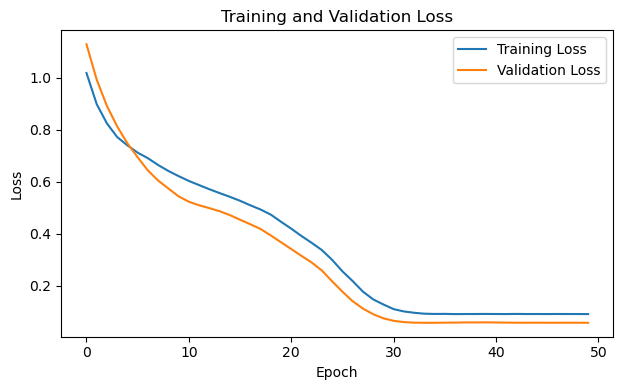

In [242]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()